# Overview

This project implements deep learning, an artificial intelligence technique, to classify x-rays from patients to predict whether or not they have pneumonia. The dataset utilized in this project is from Kaggle, and can be found here: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia <br>

In this dataset, there are over 5,800 images of x-rays from healthy patients and patients with pneumonia. The business case for establishing a robust predictive model relates to developing software to automatically read x-rays scan in patients and determine if they have pneumonia. This software could assist the efforts of radiologists or offer a better solution to diagnosing pneumonia.

## How should results be evaluated?

A good goal for this project could be creating a model that is at least better than entry-level radiologists at diagnosing pneumonia. Achieving results better than this standard would allow for more promise in creating higher achieving models that ideally would trump the performance of any radiologist. According to [IBM](https://www.ibm.com/blogs/research/2020/11/ai-x-rays-for-radiologists/), the sensitivity, specificity, and positive predictive value for radiology residents is as follows: 0.720, 0.973, and 0.682 respectively. <br>
It will be useful to review each of these metrics below.

Sensitivity and specificity are defined as the following: <br>
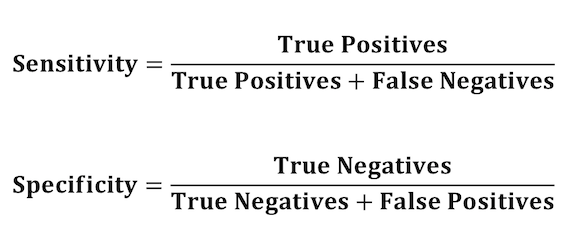

Let's review some definitions relating to this project.<br>
* True Positive- Patient is predicted to have pneumonia and does have pneumonia.
* False Negative- Patient is predicted to be healthy but does have pneumonia.
* True Negative- Patient is predicted to be healthy and is healthy.
* False Positive- Patient is predicted to have pneumonia but is healthy.

Given these definitions, sensitivity relates to how many patients are accurately predicted to have pneumonia divided by the sum of this amount and patients that are predicted to be healthy but are not. Sensitivity indicates how many patients were accurately diagnosed out of the total amount of afflicted patients.

Specificity is the amount of patients accurately predicted to be healthy divided by the sum of this number and patients predicted to have pneumonia but are healthy. Specificity indicates how many healthy patients are accurately indicated divided by the total number of healthy patients. In the case of the radiology residents, they are quite good at predicting when the patient is healthy.

Positive predictive value is defined as the following: <br>
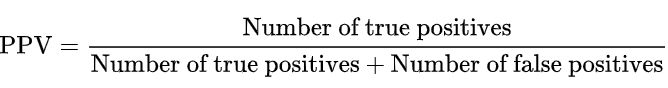

Positive predictive value is equal to the amount of patients predicted to have pneumonia and have pneumonia divided by the sum of this value and the amount of patients without pneumonia that were predicted to have it. PPV is essentially referring to how many correct positive predictions we have divided by the total amount of positive predictions. The resident radiologists were the worst in this category, which indicates that they were not very accurate in reference to the total amount of cases that were diagnosed. Given all the patients diagnosed as having pneumonia, about 68.2% actually had the disease.

It should be noted that a false negative is certainly worse than a false positive. It seems obvious that a false negative (a patient that has pneumonia but is predicted as healthy) is quite bad because this patient and the healthcare professionals may assume they are healthy and will not pursue treatment, or they will pursue more healthcare such as additional tests. A false positive is significantly better because treating pneumonia typically entails prescribing antibiotics and sometimes other medicines like cough medicine, and there are typically not significant effects that can occur from a healthy person taking antibiotics.

## Recap: Metrics used in this project

The metrics being used in this project along with the percent value of each metric signifying the goal to beat are as follows: <br>
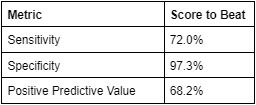

# Exploratory Data Analysis (EDA)

## Import packages and data

In [1]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path
import glob
import os
from os import listdir
from pathlib import Path

from skimage.io import imread
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

%matplotlib inline

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras import models, layers, optimizers, regularizers, activations
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import plot_confusion_matrix

import datetime

from tensorflow.random import set_seed
set_seed(13)

C:\Users\samue\anaconda_3\envs\learn-env\lib\site-packages\skimage\io\manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


## Helper functions

The following function is for labeling data from paths. This function is mainly to help with preparing the data for Exploratory Data Analysis (EDA)

In [2]:
# This function loads in data from two paths, assigns a label to the data:
# 0 for normal and 1 for pneumonia, and then combines the labeled data into a 
# dataframe
# Input: path1 (normal data), path2 (pneumonia data)
# output: dataframe
def label_data(path1, path2):
    # assign images in the paths to variables for later labeling assignments
    norm = path1.glob('*.jpeg')
    pn = path2.glob('*.jpeg')
    
    # holder for labeled images
    data = []
    
    # label normal images 0
    for img in norm:
        data.append((img,0))

    # label pneumonia as 1
    for img in pn:
        data.append((img, 1))
    
    # create dataframe with images and labels
    df = pd.DataFrame(data, columns=['image', 'pneumonia'], index=None)
    
    # randomize the data
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    
    return df

Creating paths for the data and then using the above function to label.

In [3]:
# set paths for the data files and then label the data
train_path_norm = Path('data/train/NORMAL')
train_path_pn = Path('data/train/PNEUMONIA')

test_path_norm = Path('data/test/NORMAL')
test_path_pn = Path('data/test/PNEUMONIA')

val_path_norm = Path('data/val/NORMAL')
val_path_pn = Path('data/val/PNEUMONIA')

# label and create df for train, test, and validation datasets
df_train = label_data(train_path_norm, train_path_pn) 
df_test = label_data(test_path_norm, test_path_pn)
df_val = label_data(val_path_norm, val_path_pn)

In [4]:
# check to make sure the labeling function worked.
df_train.head()

,image,pneumonia
0,data\train\PNEUMONIA\person1288_virus_2211.jpeg,1
1,data\train\NORMAL\NORMAL2-IM-0816-0001.jpeg,0
2,data\train\PNEUMONIA\person61_bacteria_290.jpeg,1
3,data\train\PNEUMONIA\person722_virus_1341.jpeg,1
4,data\train\PNEUMONIA\person1141_virus_1890.jpeg,1


* The dataframe contains the image paths for each image along with the label for each image.

## Initial look at the data

Examine images of both normal and pneumonia x-rays

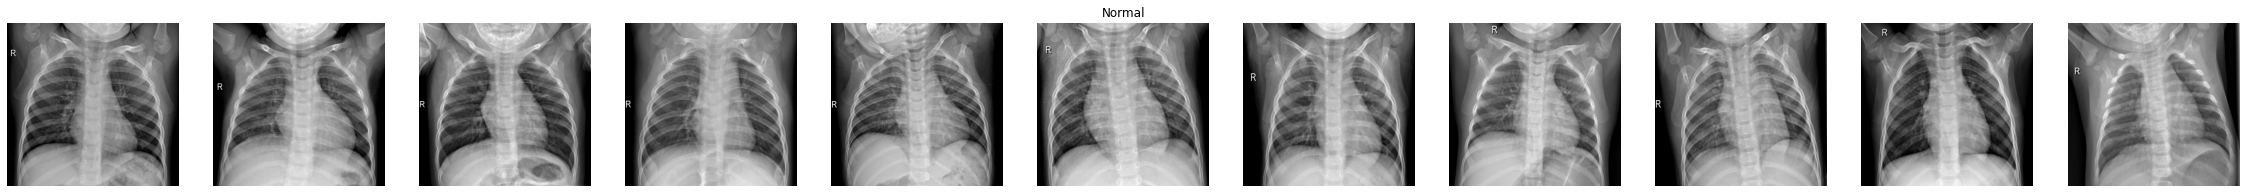

In [5]:
# plot some images of some normal x-rays
n_img = (df_train[df_train['pneumonia']==0]['image'].iloc[:11]).tolist()

fig, ax = plt.subplots(1, 11, figsize=(40, 3))
for i in range(11):
    to_plot = imread(n_img[i])
    ax[i].imshow(to_plot, cmap='gray')
    ax[i].axis('off')
    ax[i].set_aspect('auto')
    if i == 5:
        ax[i].set_title('Normal')
    
plt.show()

Normal x-rays tend to be clear, and there is typically a prevalence of black space in the imagery.

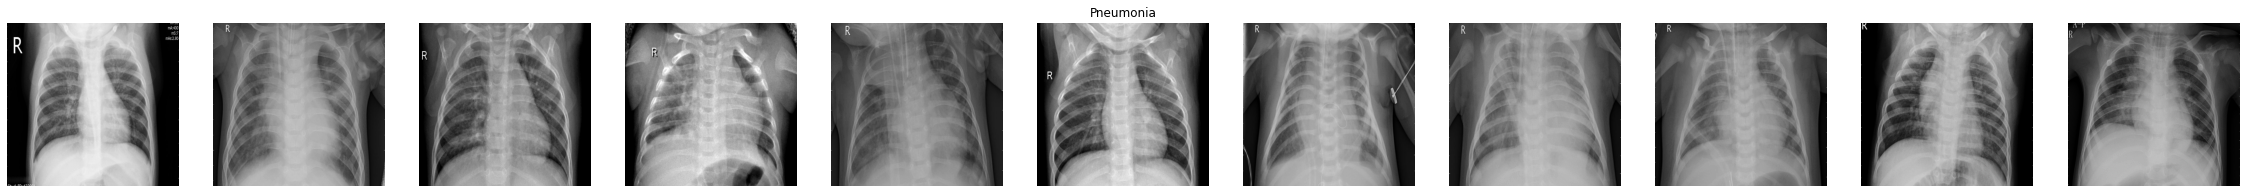

In [6]:
# plot some images of some pneumonia x-rays
pn_img = (df_train[df_train['pneumonia']==1]['image'].iloc[:11]).tolist()

fig, ax = plt.subplots(1, 11, figsize=(40, 3))
for i in range(11):
    to_plot = imread(pn_img[i])
    ax[i].imshow(to_plot, cmap='gray')
    ax[i].axis('off')
    ax[i].set_aspect('auto')
    if i == 5:
        ax[i].set_title('Pneumonia')
    
plt.show()

There is typically more cloudiness and white areas in pneumonia cases, but it is difficult to tell for some cases (at least for an untrained person) in this set.

In [7]:
# look at shape of train, test, and validation
print(df_train.shape, df_test.shape, df_val.shape)

(5216, 2) (624, 2) (16, 2)


The train set has 5,216 observations, the test set has 624 observations, and the validation set only has 16 observations.

## Observe distribution of classes in the data

In [8]:
# look into class imbalance in each set
x1 = df_train['pneumonia'].value_counts()
x2 = df_test['pneumonia'].value_counts()
x3 = df_val['pneumonia'].value_counts()
print(x1)
print(x2)
print(x3)

1    3875
0    1341
Name: pneumonia, dtype: int64
1    390
0    234
Name: pneumonia, dtype: int64
1    8
0    8
Name: pneumonia, dtype: int64


* There are 3875 normal xrays and 1341 pneumonia xrays in train data
* There are 390 normal xrays and 234 pneumonia xrays in the test data
* There are 8 normal xrays and 8 pneumonia xrays in the validation data

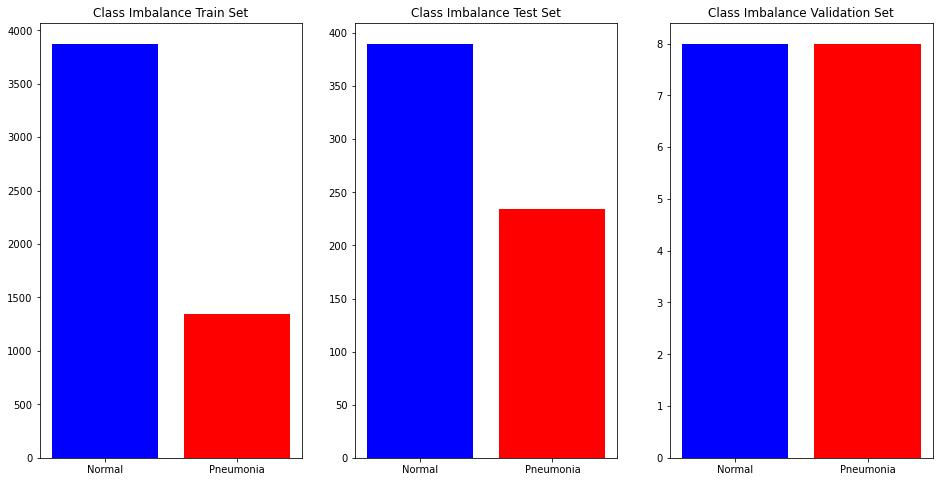

In [9]:
# visualize class imbalance in all three data sets
fig, ax = plt.subplots(1, 3, figsize=(16,8), sharey=False)
ax[0].bar(['Normal', 'Pneumonia'], [3875, 1341], color=['b', 'r'])
ax[0].set_title('Class Imbalance Train Set')

ax[1].bar(['Normal', 'Pneumonia'], [390, 234], color=['b', 'r'])
ax[1].set_title('Class Imbalance Test Set')

ax[2].bar(['Normal', 'Pneumonia'], [8, 8], color=['b', 'r'])
ax[2].set_title('Class Imbalance Validation Set')
    
plt.show()

* There is more class imbalance in the train set than the other two.
* There is equal class balance in the validation set, but there are only 16 total observations in the validation set.
* The class imbalance is not severe and probably does not to be accounted for in the modeling phase.

# Modeling

## Prepare images for modeling

Use ImageDataGenerator to permute the data and artificially generate more data. 

In [10]:
# ImageDataGenerators for train, test, validation
# generate images
permutes = ImageDataGenerator(
    rescale = 1. / 255,     # multiply the data by the value provided
    shear_range = 0.2,     # this distorts the image along an axis
    zoom_range = 0.2,     # range for random zoom
    horizontal_flip = True     # random horizontal flip
)

# initialize variables to reduce redundancies
batch_size = 16     #  number of samples that the NN uses each iteration

train_gen = permutes.flow_from_directory(
    'data/train',
    target_size = (224, 224),
    batch_size = 5216,
    class_mode = 'binary'
)

test_gen = permutes.flow_from_directory(
    'data/test',
    target_size = (224, 224),
    batch_size = 624,
    class_mode = 'binary'
)

val_gen = permutes.flow_from_directory(
    'data/val',
    target_size = (224, 224),
    batch_size = batch_size,
    class_mode = 'binary'
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


## Train-Test-Validation datasets

In [11]:
# Create the data sets with the train/test/val splits
X_train, y_train = next(train_gen)
X_test, y_test = next(test_gen)
X_val, y_val = next(val_gen)

Preview an image in one of the sets

In [12]:
X_train[2]

array([[[0.28165516, 0.28165516, 0.28165516],
        [0.2898765 , 0.2898765 , 0.2898765 ],
        [0.28670993, 0.28670993, 0.28670993],
        ...,
        [0.3112553 , 0.3112553 , 0.3112553 ],
        [0.30588236, 0.30588236, 0.30588236],
        [0.30588236, 0.30588236, 0.30588236]],

       [[0.28165516, 0.28165516, 0.28165516],
        [0.2898765 , 0.2898765 , 0.2898765 ],
        [0.28670993, 0.28670993, 0.28670993],
        ...,
        [0.3112553 , 0.3112553 , 0.3112553 ],
        [0.30588236, 0.30588236, 0.30588236],
        [0.30588236, 0.30588236, 0.30588236]],

       [[0.28165516, 0.28165516, 0.28165516],
        [0.2898765 , 0.2898765 , 0.2898765 ],
        [0.28670993, 0.28670993, 0.28670993],
        ...,
        [0.3112553 , 0.3112553 , 0.3112553 ],
        [0.30588236, 0.30588236, 0.30588236],
        [0.30588236, 0.30588236, 0.30588236]],

       ...,

       [[0.37501922, 0.37501922, 0.37501922],
        [0.3556709 , 0.3556709 , 0.3556709 ],
        [0.3050058 , 0

* The data structure above represents an x-ray in the training set.
* The permuted values can be seen (i.e. rescaling)

## Model 1: Baseline

Build a neural net with a few layers for the first model.

Binary cross entropy will be used as the loss function. It can be visualized below: <br>
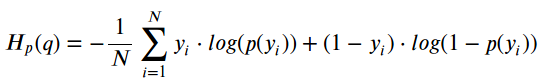

Put very simply, this formula is penalizing false predictions and rewarding true predictions. For a more detailed explanation of why this formula is used, refer to [this article](https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a).

The optimizer used for the baseline model is Stochastic Gradient Descent (SGD). More on optimizers can be found [here](https://ruder.io/optimizing-gradient-descent/index.html#stochasticgradientdescent).

In [13]:
# Baseline model
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(
    loss='binary_crossentropy',     # loss function should be binary for 2 col
    optimizer='sgd',
    metrics=['acc']
)

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 43264)             0

In [15]:
original_start = datetime.datetime.now()
start = datetime.datetime.now()

history = model.fit(
    X_train,
    y_train,
    epochs=1,
    validation_data=(X_val, y_val)
)

end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

163/163 [==============================] - 191s 1s/step - loss: 0.5384 - acc: 0.7504 - val_loss: 0.6168 - val_acc: 0.6250
Training took a total of 0:03:14.301009


In [16]:
# evaluate model accuracy
scores = model.evaluate(test_gen)
print()
print('Model Accuracy: {}%'.format(scores[1]*100))
print('Model Loss: {}%'.format(scores[0]))

1/1 [==============================] - 0s 6ms/step - loss: 0.5258 - acc: 0.7580

Model Accuracy: 75.80128312110901%
Model Loss: 0.5257883071899414%


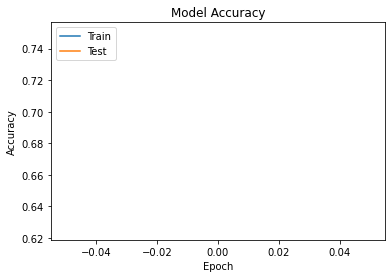

In [17]:
# model accuracy plot
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

* Notice lack of convergence between train and test set in terms of accuracy
* it looks like additional epochs did not have much effect on the testing accuracy but did improve training results.

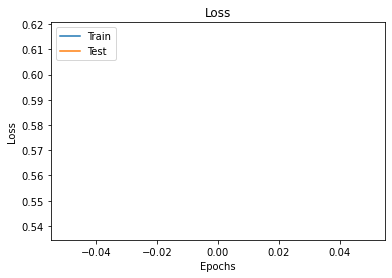

In [18]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Test'], loc='upper left')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

* Again, lack of convergence...
* It doesn't seem like additional epochs have an effect on validation loss.

In [19]:
# Create predictions for the model
y_hat_tmp = history.model.predict(X_test)

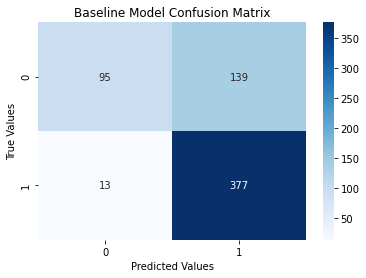

In [20]:
# classify y_hat as either 0 or 1 based on if val is < or >= to 0.5
thresh = 0.5
y_hat = (y_hat_tmp > thresh).astype(np.int)     # cast 0 or 1 to y_hat values

y_t = y_test.astype(np.int)     # cast 0 or 1 to y_test values

cm_vals = confusion_matrix(y_t, y_hat)     # get confusion matrix values

# plot confusion matrix values
sns.heatmap(
    cm_vals, 
    annot=True, 
    cmap='Blues', 
    fmt='0.5g'
)

plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title('Baseline Model Confusion Matrix')
plt.show()

In [21]:
sensitivity = 376 / (376+14)
ppv = 376 / (376+74)
specificity = 160 / (160+74)

print(sensitivity, ppv, specificity)

0.9641025641025641 0.8355555555555556 0.6837606837606838


* Sensitivity is much better than the radiology residents.
* Positive Predictive Value is 83.6%, which is more than 10% better than the residents.
* Specificity is almost 30% worse in this model compared to the residents.
* The model did not produce many false negatives, which is quite good!

The false positive rate is fairly high. These are patients that do not have pneumonia, but were predicted as having the disease. There were not many false negatives, which is good because it is better to overdiagnose than underdiagnose this disease because people that are not diagnosed with the disease but actually have it are more likely to suffer more from the disease because they will not receive immediate treatment.

## Model 2: VGG-19

From [MathWork's description](https://www.mathworks.com/help/deeplearning/ref/vgg19.html): "VGG-19 is a convolutional neural network that is 19 layers deep. You can load a pretrained version of the network trained on more than a million images from the ImageNet database". <br> Additionally, [this article](https://iq.opengenus.org/vgg19-architecture/) explains the architecture of VGG-19 more fully.

In [22]:
# instantiate a VGG19 parameters w/ pre-determined weights from imagenet 
vgg_params = VGG19(
     weights='imagenet',
     include_top=True
)

vgg_params.trainable = False

mod2 = models.Sequential()
mod2.add(vgg_params)
mod2.add(Flatten())
mod2.add(Dense(64, activation='relu'))
mod2.add(Dense(1, activation='sigmoid'))

In [23]:
# Compile the model
mod2.compile(
        loss='binary_crossentropy', 
        optimizer='RMSprop', 
        metrics=['acc']
)

In [24]:
mod2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 1000)              143667240 
_________________________________________________________________
flatten_1 (Flatten)          (None, 1000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                64064     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 143,731,369
Trainable params: 64,129
Non-trainable params: 143,667,240
_________________________________________________________________


In [25]:
# fit the model and track time taken to train the model
original_start = datetime.datetime.now()
start = datetime.datetime.now()

history = mod2.fit(
    X_train,
    y_train,
    epochs=1,
    batch_size=16,
    validation_data=(X_val, y_val)
)

end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

326/326 [==============================] - 1343s 4s/step - loss: 0.5824 - acc: 0.7410 - val_loss: 0.8157 - val_acc: 0.5000
Training took a total of 0:22:29.237684


In [ ]:
# evaluate model accuracy & loss
# scores = mod2.evaluate(test_gen)
# print()
# print('Model Accuracy: {}%'.format(scores[1]*100))

In [ ]:
# # evaluate model loss 
# losses = mod2.evaluate(test_gen)
# print()
# print('Model Loss: {}%'.format(scores[0]*100))

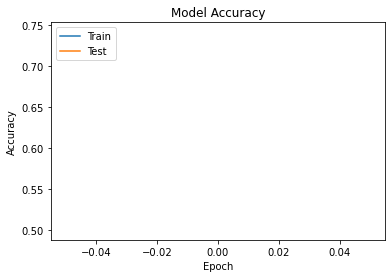

In [26]:
# model accuracy plot
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

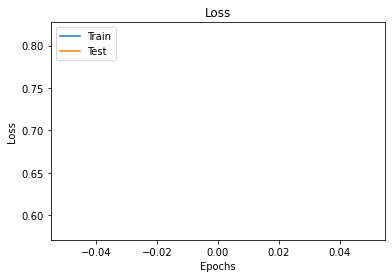

In [27]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Test'], loc='upper left')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

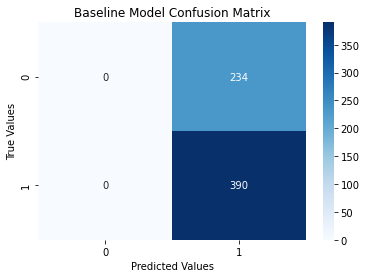

In [28]:
# Create predictions for the model
y_hat_tmp = history.model.predict(X_test)

# classify y_hat as either 0 or 1 based on if val is < or >= to 0.5
thresh = 0.5
y_hat = (y_hat_tmp > thresh).astype(np.int)     # cast 0 or 1 to y_hat values

y_t = y_test.astype(np.int)     # cast 0 or 1 to y_test values

cm_vals = confusion_matrix(y_t, y_hat)     # get confusion matrix values

# plot confusion matrix values
sns.heatmap(
    cm_vals, 
    annot=True, 
    cmap='Blues', 
    fmt='0.5g'
)

plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title('Baseline Model Confusion Matrix')
plt.show()

In [29]:
print(classification_report(y_t, y_hat))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       234
           1       0.62      1.00      0.77       390

    accuracy                           0.62       624
   macro avg       0.31      0.50      0.38       624
weighted avg       0.39      0.62      0.48       624



C:\Users\samue\anaconda_3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


There are quite a few false positives, but not many false negatives.

## Model 3: VGG-19

Reducing the size of the training set to improve speed of the model. This reduction will also balance class distribution (remove imbalance).

### Subsample Training Images and Pre-Process

In [30]:
# use df_train to randomly select 250 images with 0 and 1 from pneumonnia col
df_tmp_norm = df_train[df_train.pneumonia==0]
df_tmp_n = df_tmp_norm.sample(n=250, random_state=42)
df_tmp_pn = df_train[df_train.pneumonia==1]
df_tmp_pn1 = df_tmp_pn.sample(n=250, random_state=42)

# concatenate dfs and then randomize
df_t3 = pd.concat([df_tmp_n, df_tmp_pn1])
df_t3 = df_t3.sample(frac=1)     # randomize
df_t3 = df_t3.reset_index(drop=True)
df_t3

,image,pneumonia
0,data\train\NORMAL\IM-0733-0001.jpeg,0
1,data\train\NORMAL\NORMAL2-IM-0941-0001.jpeg,0
2,data\train\NORMAL\IM-0586-0001.jpeg,0
3,data\train\NORMAL\IM-0580-0001.jpeg,0
4,data\train\PNEUMONIA\person1858_bacteria_4730....,1
...,...,...
495,data\train\NORMAL\IM-0602-0001.jpeg,0
496,data\train\NORMAL\IM-0261-0001.jpeg,0
497,data\train\NORMAL\NORMAL2-IM-0391-0001.jpeg,0
498,data\train\NORMAL\NORMAL2-IM-0897-0001.jpeg,0


Now that the data is subsampled, the file paths for each image needs to be read as an image and stored as an array.

In [31]:
# PIL image processing
from PIL import Image

images = []

for index, row in df_t3.iterrows():
    path=row['image']
    image = load_img(path, grayscale=False, color_mode="rgb", 
                     target_size=(224, 224), interpolation="nearest")
    img_arr = img_to_array(image)
    images.append(img_arr)

In [32]:
# cast x and y train (images and y_train3) to np.arrays in order to fit
images = np.array(images)
y_train3 = np.array(df_t3.pneumonia)

### Create and fit model

In [33]:
# instantiate a VGG19 parameters w/ pre-determined weights from imagenet 
vgg_params = VGG19(
    weights='imagenet',
    include_top=False,
    input_tensor=Input(shape=(224, 224, 3))
)

vgg_params.trainable = False

mod3 = models.Sequential()

mod3.add(vgg_params)
mod3.add(Flatten())
mod3.add(Dense(64, activation='relu'))
mod3.add(Dense(1, activation='sigmoid'))

mod3.compile(loss='binary_crossentropy',
                optimizer='RMSprop',
                metrics=['acc'])

In [34]:
mod3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                1605696   
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 21,630,145
Trainable params: 1,605,761
Non-trainable params: 20,024,384
_________________________________________________________________


Large amount of non-trainable parameters because the model is using predetermined weights from imagenet.

In [35]:
original_start = datetime.datetime.now()
start = datetime.datetime.now()

# Generate augmented images
img_perms = ImageDataGenerator(
    rescale = 1. / 255,     # multiply the data by the value provided
    shear_range = 0.2,     # this distorts the image along an axis
    zoom_range = 0.2,     # range for random zoom
    horizontal_flip = True     # random horizontal flip
)

history = mod3.fit(
    img_perms.flow(images, y_train3, batch_size=32),
    epochs=20,
    validation_data=(X_val, y_val),
)

end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

Epoch 1/20
16/16 [==============================] - 78s 5s/step - loss: 1.7978 - acc: 0.6640 - val_loss: 0.5229 - val_acc: 0.7500
Epoch 2/20
16/16 [==============================] - 74s 5s/step - loss: 0.3857 - acc: 0.8440 - val_loss: 0.4817 - val_acc: 0.7500
Epoch 3/20
16/16 [==============================] - 73s 5s/step - loss: 0.3188 - acc: 0.8720 - val_loss: 0.7120 - val_acc: 0.6875
Epoch 4/20
16/16 [==============================] - 73s 5s/step - loss: 0.2913 - acc: 0.8920 - val_loss: 0.7067 - val_acc: 0.6875
Epoch 5/20
16/16 [==============================] - 74s 5s/step - loss: 0.2736 - acc: 0.8940 - val_loss: 0.5058 - val_acc: 0.7500
Epoch 6/20
16/16 [==============================] - 76s 5s/step - loss: 0.2488 - acc: 0.9120 - val_loss: 0.5077 - val_acc: 0.7500
Epoch 7/20
16/16 [==============================] - 79s 5s/step - loss: 0.2452 - acc: 0.8960 - val_loss: 0.7060 - val_acc: 0.6875
Epoch 8/20
16/16 [==============================] - 80s 5s/step - loss: 0.2441 - acc: 0.89

In [ ]:
# evaluate model accuracy
scores = mod3.evaluate(test_gen)
print('Model Accuracy: {}%'.format(scores[1]*100))
print('Model Loss: {}%'.format(scores[0]))

In [ ]:
# model accuracy plot
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Test'], loc='upper left')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
# Create predictions for the model
y_hat_tmp = history.model.predict(images)
# classify y_hat as either 0 or 1 based on if val is < or >= to 0.5
thresh = 0.5
y_hat = (y_hat_tmp > thresh).astype(np.int)     # cast 0 or 1 to y_hat values

y_t = y_test3.astype(np.int)     # cast 0 or 1 to y_test values

cm_vals = confusion_matrix(y_t, y_hat)     # get confusion matrix values

# plot confusion matrix values
sns.heatmap(
    cm_vals, 
    annot=True, 
    cmap='Blues', 
    fmt='0.5g'
)

plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title('Baseline Model Confusion Matrix')
plt.show()

So many false positives in this model iteration!

## Model 4: Dropout Regularization

In [ ]:
mod4 = models.Sequential()

mod4.add(Conv2D(32, kernel_size=(3, 3), activation='relu',
                    input_shape=(224, 224, 3)))
mod4.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
mod4.add(MaxPooling2D((2, 2)))

mod4.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
mod4.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
mod4.add(MaxPooling2D(2, 2))

mod4.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
mod4.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
mod4.add(MaxPooling2D((2, 2)))

mod4.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
mod4.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
mod4.add(MaxPooling2D((2, 2)))

# add dropout regularization
mod4.add(layers.Flatten())
mod4.add(layers.Dense(512, activation='relu'))
mod4.add(layers.Dropout(0.3))
mod4.add(layers.Dense(512, activation='relu'))
mod4.add(layers.Dropout(0.3))
mod4.add(layers.Dense(1, activation='sigmoid'))

# Compile the model
mod4.compile(
    optimizer='RMSprop', 
    loss='binary_crossentropy', 
    metrics=['acc']
)

mod4.summary()

In [ ]:
original_start = datetime.datetime.now()
start = datetime.datetime.now()

history = mod4.fit(
    X_train, 
    y_train,
    validation_data=(X_test, y_test),
    epochs=50
)

end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

In [ ]:
# evaluate model accuracy
scores = mod4.evaluate(test_gen)
print('Model Accuracy: {}%'.format(scores[1]*100))
print('Model Loss: {}%'.format(scores[0]))

In [ ]:
# model accuracy plot
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Test'], loc='upper left')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
# Create predictions for the model
y_hat_tmp = history.model.predict(X_test)
# classify y_hat as either 0 or 1 based on if val is < or >= to 0.5
thresh = 0.5
y_hat = (y_hat_tmp > thresh).astype(np.int)     # cast 0 or 1 to y_hat values

y_t = y_test.astype(np.int)     # cast 0 or 1 to y_test values

cm_vals = confusion_matrix(y_t, y_hat)     # get confusion matrix values

# plot confusion matrix values
sns.heatmap(
    cm_vals, 
    annot=True, 
    cmap='Blues', 
    fmt='0.5g'
)

plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title('Baseline Model Confusion Matrix')
plt.show()

## Model 5: Optimize Best Model

This model will try to optimize the best model so far and produce a better model.